## Tensor Product at `GPU` is much faster then `CPU`

Most deep learning calculation is held by `Matrix Multiplication`<br>
We will make `Dezero` to use `GPU`

---

- install `cupy` for `GPU` usage
    - Library for parallel calculation using GPU

```python
$ pip install cupy
```

## `Numpy` and `Cupy` usage is almost the same

In [1]:
import cupy as cp

C:\Users\hyunb\anaconda3\lib\site-packages\cupy\_environment.py:206: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


ImportError: CuPy is not correctly installed.

If you are using wheel distribution (cupy-cudaXX), make sure that the version of CuPy you installed matches with the version of CUDA on your host.
Also, confirm that only one CuPy package is installed:
  $ pip freeze

If you are building CuPy from source, please check your environment, uninstall CuPy and reinstall it with:
  $ pip install cupy --no-cache-dir -vvvv

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

original error: DLL load failed: 지정된 모듈을 찾을 수 없습니다.

In [13]:
def show_progress(block_num, block_size, total_size):
    bar_template = "\r[{}] {:.2f}%"
    
    downloaded = block_num * block_size
    
    p = downloaded / total_size * 100
    i = int(downloaded / total_size * 30)
    if p >= 100.0: p = 100.0
    if i >= 30: i=30
    
    bar = "#" * i + "." * (30 - i)
    print(bar_template.format(bar, p), end='')

In [25]:
for i in range(100):
    # pause a bit
    for _ in range(1000000):
        _pause = 1
    show_progress(block_num=i + 1, block_size=10, total_size=1000)

[##############################] 100.00%

### cache directory

In [27]:
import os

cache_dir = os.path.join(os.path.expanduser('~'), '.dezero')

### get file

In [3]:
url = 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz'

url.rfind('/') + 1

33

In [4]:
url[url.rfind('/') + 1:]

'train-images-idx3-ubyte.gz'

In [28]:
import urllib.request


def get_file(url, file_name=None):
    """Download a file from the `url` if it is not in the cache.
    
    The file at the `url` is downloaded to the `~/.dezero`
    
    Args:
        url (str): URL of the file.
        file_name (str): Name of the file.
                         If `None` is specified the original file name is used.
                         
    Returns:
        str: Absolute path to the saved file
    """
    if file_name is None:
        file_name = url[url.rfind('/') + 1:]
    
    # Check is cache directory exist
    if not os.path.exists(cache_dir):
        os.mkdir(cache_dir)
   
    file_path = os.path.join(cache_dir, file_name)
    
    if os.path.exists(file_path):
        return file_path
    
    print("Downloading: " + file_name)
    try:
        urllib.request.urlretrieve(url, file_path, show_progress)
    except (Exception, KeyboardInterrupt) as e:
        if os.path.exists(file_path):
            os.remove(file_path)
        raise
    
    print(" Done")
    
    return file_path

### `MNIST` Dataset

```python
import gzip
import matplotlib.pyplot as plt

from dezero.utils import get_file, cache_dir
from dezero.transforms import Compose, Flatten, ToFloat, Normalize


class MNIST(Dataset):
    def __init__(self,
                 train=True,
                 transform=Compose([Flatten(),
                                    ToFloat(),
                                    Normalize(0., 255.)]),
                 target_transform=None):
        super().__init__(train, transform, target_transform)
        
    def prepare(self):
        url = "http://yann.lecun.com/exdb/mnist/"
        train_files = {'target': 'train-images-idx3-ubyte.gz',
                       'label': 'train-labels-idx1-ubyte.gz'}
        test_files = {'target': 't10k-images-idx3-ubyte.gz',
                      'label': 't10k-labels-idx1-ubyte.gz'}
        
        files = train_files if self.train else test_files
        
        data_path = get_file(url + files['target'])
        label_path = get_file(url + files['label'])
        
        self.data = self._load_data(data_path)
        self.label = self._load_label(label_path)
        
    def _load_label(self, filepath):
        with gzip.open(filepath, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
        return labels
    
    def _load_data(self, filepath):
        with gzip.open(filepath, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return data
    
    def show(self, row=10, col=10):
        H, W = 28, 28
        img = np.zeros((H * row, W * col))
        for r in range(row):
            for c in range(col):
                # Get random images from MNIST and place it at numpy array
                img[r * H:(r + 1) * H, c * W:(c + 1) * W] = self.data[
                    np.random.randint(0, len(self.data) - 1)].reshape(H, W)
        
        plt.imshow(img, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.show()
        
    @staticmethod
    def labels():
        return {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
```

### what is `np.frombuffer`?

`np.frombuffer` is used when we want to `array` from `byte` data!

In [43]:
# should choose the size of data
np.frombuffer(b'\x01\x02')

ValueError: buffer size must be a multiple of element size

### byte array is `little endian` here

In [49]:
import sys
sys.byteorder

'little'

So when we choose `np.uint8` it cuts by 8 and reverse the order.<br>

- real memory : `1` `2`
---
- little endian interpret : `1` `2`

In [51]:
# 0000 0001 = 1 / 0000 0010 = 2
np.frombuffer(b'\x01\x02', dtype=np.uint8)

array([1, 2], dtype=uint8)

When we choose `np.uint16` it cuts by 16 and reverse the order.<br>

- real memory : `1 2`
---
- little endian interpret : `2 1`

In [52]:
# 0000 0010 0000 0001 = 513
np.frombuffer(b'\x01\x02', dtype=np.uint16)

array([513], dtype=uint16)

- real memory : `2 1`
---
- little endian interpret : `1 2`

In [53]:
# 0000 0001 0000 0010 = 258
np.frombuffer(b'\x02\x01', dtype=np.uint16)

array([258], dtype=uint16)

- real memory : `1 2` `2 1`
---
- little endian interpret : `2 1` `1 2`

In [54]:
np.frombuffer(b'\x01\x02\x02\x01', dtype=np.uint16)

array([513, 258], dtype=uint16)

- real memory : `1 2` `3 4`
---
- little endian interpret : `2 1` `4 3`

In [55]:
np.frombuffer(b'\x01\x02\x03\x04', dtype=np.uint16)

array([ 513, 1027], dtype=uint16)

This means when we want to print in write order for example `1 2` `3 4`<br>
The system will consider this as `little endian` so we should write it as `little endian`!

- `b'\x01\x02\x03\x04'` -> `b'\x02\x01\x04\x03'`

- real memory : `2 1` `4 3`
---
- little endian interpret : `1 2` `3 4`

In [56]:
np.frombuffer(b'\x02\x01\x04\x03', dtype=np.uint16)

array([258, 772], dtype=uint16)

Look's great :)

- real memory : `1 2` `3 4` `5 6`
---
- little endian interpret : `2 1` `4 3` `6 5`

In [57]:
np.frombuffer(b'\x01\x02\x03\x04\x05\06', dtype=np.uint16, count=3)

array([ 513, 1027, 1541], dtype=uint16)

## Looking around with `MNIST`

In [1]:
import dezero

train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=False, transform=None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: t10k-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
10000


In [2]:
x, y = train_set[0]
print(type(x), x.shape)
print(y)

<class 'numpy.ndarray'> (1, 28, 28)
5


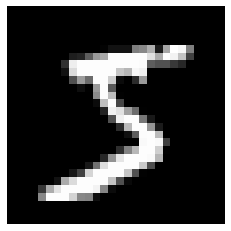

label:  5


In [4]:
import matplotlib.pyplot as plt

x, y = train_set[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

print('label: ', y)

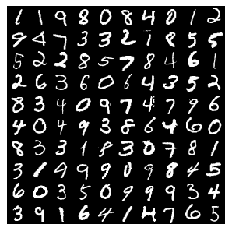

In [9]:
train_set.show()

### Input preprocessing for `train`

1. flatten
2. dtype conversion to `float32`
3. Normalize with `255`

In [10]:
def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.
    return x

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

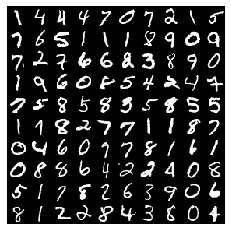

In [11]:
train_set.show()

## Training with `MNIST`

In [1]:
import math
import numpy as np

import dezero
from dezero import optimizers
from dezero import DataLoader

import dezero.functions as F
from dezero.models import MLP
from dezero.datasets import MNIST

In [13]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = MNIST(train=True)
test_set = MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr=0.1).setup(model)

In [15]:
epoch_list = []

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []


for epoch in range(max_epoch):
    
    sum_loss, sum_acc = 0, 0
    
    for x, y in train_loader:
        y_pred = model(x)
        
        loss = F.softmax_cross_entropy(y_pred, y)
        acc = F.accuracy(y_pred, y)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(y)
        sum_acc += float(acc.data) * len(y)
    
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)

    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    
    print('epoch : {}'.format(epoch + 1))
    print('train loss {:.4f}, accuracy {:.4f}'.format(avg_loss, avg_acc))

    
    sum_loss, sum_acc = 0, 0
    
    with dezero.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            
            loss = F.softmax_cross_entropy(y_pred, y)
            acc = F.accuracy(y_pred, y)
            
            sum_loss += float(loss.data) * len(y)
            sum_acc += float(acc.data) * len(y)
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)            
    
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(avg_loss, avg_acc))
    
    epoch_list.append(epoch + 1)    

epoch : 1
train loss 0.0892, accuracy 0.1667
test loss: 0.4418, accuracy: 0.8756
epoch : 2
train loss 0.4010, accuracy 0.8834
test loss: 0.3465, accuracy: 0.9001
epoch : 3
train loss 0.3511, accuracy 0.8976
test loss: 0.3135, accuracy: 0.9094
epoch : 4
train loss 0.3299, accuracy 0.9032
test loss: 0.3070, accuracy: 0.9145
epoch : 5
train loss 0.3161, accuracy 0.9086
test loss: 0.2939, accuracy: 0.9149


### Loss & acuracy graph

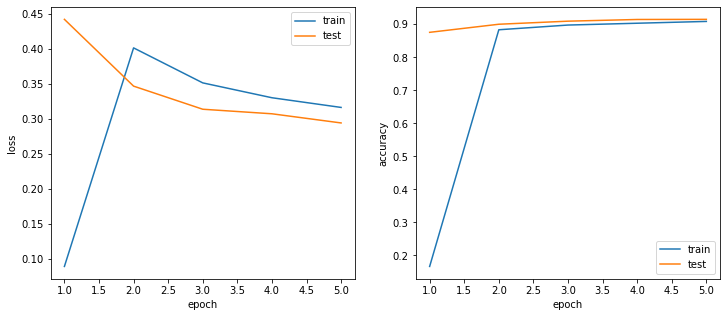

In [21]:
import matplotlib.pyplot as plt

def plot_loss_acc():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, train_loss_list, label='train')
    plt.plot(epoch_list, test_loss_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, train_acc_list, label='train')
    plt.plot(epoch_list, test_acc_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend()
    plt.show()
    
plot_loss_acc()

### We reached `91.49%` accuracy at test set!

## `ReLU` - rectified linear unit

In [22]:
x = np.array([[1, 2, -1],
              [-1, 2, 1],
              [-3, -3, -7]])
x > 0

array([[ True,  True, False],
       [False,  True,  True],
       [False, False, False]])

In [23]:
x * (x > 0)

array([[1, 2, 0],
       [0, 2, 1],
       [0, 0, 0]])

In [ ]:
class ReLU(Function):
    def forward(self, x):
        y = np.maximum(x, 0.0)
        return y
    
    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0
        gx = gy * mask
        return gx
    
def relu(x):
    return ReLU()(x)

In [2]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = MNIST(train=True)
test_set = MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10), activation=F.relu)
optimizer = optimizers.SGD(lr=0.1).setup(model)

In [3]:
epoch_list = []

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []


for epoch in range(max_epoch):
    
    sum_loss, sum_acc = 0, 0
    
    for x, y in train_loader:
        y_pred = model(x)
        
        loss = F.softmax_cross_entropy(y_pred, y)
        acc = F.accuracy(y_pred, y)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(y)
        sum_acc += float(acc.data) * len(y)
    
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)

    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    
    print('epoch : {}'.format(epoch + 1))
    print('train loss {:.4f}, accuracy {:.4f}'.format(avg_loss, avg_acc))

    
    sum_loss, sum_acc = 0, 0
    
    with dezero.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            
            loss = F.softmax_cross_entropy(y_pred, y)
            acc = F.accuracy(y_pred, y)
            
            sum_loss += float(loss.data) * len(y)
            sum_acc += float(acc.data) * len(y)
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)            
    
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(avg_loss, avg_acc))
    
    epoch_list.append(epoch + 1)    

epoch : 1
train loss 0.4217, accuracy 0.8879
test loss: 0.2491, accuracy: 0.9303
epoch : 2
train loss 0.2268, accuracy 0.9364
test loss: 0.1924, accuracy: 0.9449
epoch : 3
train loss 0.1746, accuracy 0.9510
test loss: 0.1553, accuracy: 0.9549
epoch : 4
train loss 0.1418, accuracy 0.9605
test loss: 0.1325, accuracy: 0.9622
epoch : 5
train loss 0.1199, accuracy 0.9665
test loss: 0.1202, accuracy: 0.9653


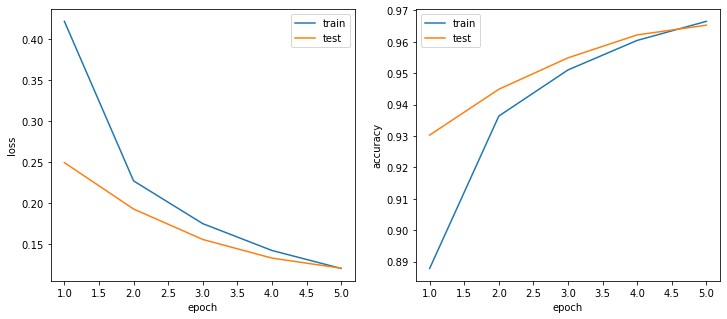

In [4]:
import matplotlib.pyplot as plt

def plot_loss_acc():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, train_loss_list, label='train')
    plt.plot(epoch_list, test_loss_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, train_acc_list, label='train')
    plt.plot(epoch_list, test_acc_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend()
    plt.show()
    
plot_loss_acc()

### `ReLU` add ->  `96.53%` accuracy at test set!

## With `Adam`

In [25]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = MNIST(train=True)
test_set = MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10), activation=F.relu)
optimizer = optimizers.Adam(lr=0.01).setup(model)

In [26]:
epoch_list = []

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []


for epoch in range(max_epoch):
    
    sum_loss, sum_acc = 0, 0
    
    for x, y in train_loader:
        y_pred = model(x)
        
        loss = F.softmax_cross_entropy(y_pred, y)
        acc = F.accuracy(y_pred, y)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(y)
        sum_acc += float(acc.data) * len(y)
    
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)

    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    
    print('epoch : {}'.format(epoch + 1))
    print('train loss {:.4f}, accuracy {:.4f}'.format(avg_loss, avg_acc))

    
    sum_loss, sum_acc = 0, 0
    
    with dezero.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            
            loss = F.softmax_cross_entropy(y_pred, y)
            acc = F.accuracy(y_pred, y)
            
            sum_loss += float(loss.data) * len(y)
            sum_acc += float(acc.data) * len(y)
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)            
    
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(avg_loss, avg_acc))
    
    epoch_list.append(epoch + 1)    

epoch : 1
train loss 0.1879, accuracy 0.9430
test loss: 0.1151, accuracy: 0.9616
epoch : 2
train loss 0.0791, accuracy 0.9756
test loss: 0.0933, accuracy: 0.9712
epoch : 3
train loss 0.0540, accuracy 0.9826
test loss: 0.0818, accuracy: 0.9758
epoch : 4
train loss 0.0409, accuracy 0.9863
test loss: 0.0904, accuracy: 0.9745
epoch : 5
train loss 0.0343, accuracy 0.9889
test loss: 0.0807, accuracy: 0.9783


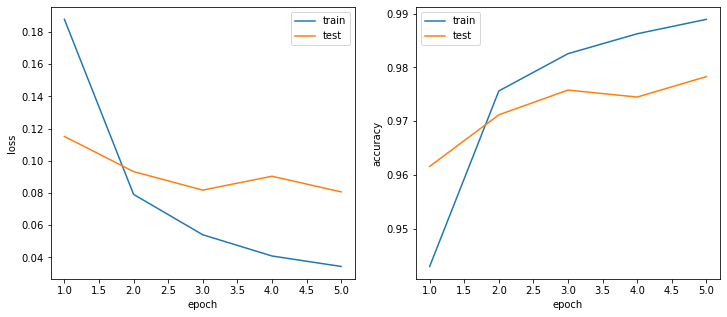

In [27]:
import matplotlib.pyplot as plt

def plot_loss_acc():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, train_loss_list, label='train')
    plt.plot(epoch_list, test_loss_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, train_acc_list, label='train')
    plt.plot(epoch_list, test_acc_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend()
    plt.show()
    
plot_loss_acc()

### `ReLU` + `Adam lr=0.01` add ->  `97.83%` accuracy at test set!

## With `3 Layer MLP`

In [22]:
max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set = MNIST(train=True)
test_set = MNIST(train=False)

train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
optimizer = optimizers.Adam(lr=0.001).setup(model)

In [23]:
epoch_list = []

train_loss_list = []
test_loss_list = []

train_acc_list = []
test_acc_list = []


for epoch in range(max_epoch):
    
    sum_loss, sum_acc = 0, 0
    
    for x, y in train_loader:
        y_pred = model(x)
        
        loss = F.softmax_cross_entropy(y_pred, y)
        acc = F.accuracy(y_pred, y)
        
        model.cleargrads()
        loss.backward()
        optimizer.update()
        
        sum_loss += float(loss.data) * len(y)
        sum_acc += float(acc.data) * len(y)
    
    avg_loss = sum_loss / len(train_set)
    avg_acc = sum_acc / len(train_set)

    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    
    print('epoch : {}'.format(epoch + 1))
    print('train loss {:.4f}, accuracy {:.4f}'.format(avg_loss, avg_acc))

    
    sum_loss, sum_acc = 0, 0
    
    with dezero.no_grad():
        for x, y in test_loader:
            y_pred = model(x)
            
            loss = F.softmax_cross_entropy(y_pred, y)
            acc = F.accuracy(y_pred, y)
            
            sum_loss += float(loss.data) * len(y)
            sum_acc += float(acc.data) * len(y)
            
    avg_loss = sum_loss / len(test_set)
    avg_acc = sum_acc / len(test_set)            
    
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(avg_loss, avg_acc))
    
    epoch_list.append(epoch + 1)    

epoch : 1
train loss 0.2561, accuracy 0.9273
test loss: 0.1121, accuracy: 0.9668
epoch : 2
train loss 0.0907, accuracy 0.9728
test loss: 0.0823, accuracy: 0.9742
epoch : 3
train loss 0.0553, accuracy 0.9837
test loss: 0.0668, accuracy: 0.9784
epoch : 4
train loss 0.0372, accuracy 0.9879
test loss: 0.0737, accuracy: 0.9765
epoch : 5
train loss 0.0259, accuracy 0.9916
test loss: 0.0590, accuracy: 0.9813


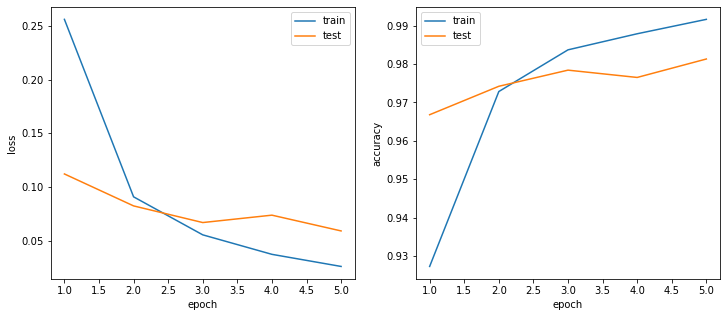

In [24]:
import matplotlib.pyplot as plt

def plot_loss_acc():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, train_loss_list, label='train')
    plt.plot(epoch_list, test_loss_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, train_acc_list, label='train')
    plt.plot(epoch_list, test_acc_list, label='test')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')

    plt.legend()
    plt.show()
    
plot_loss_acc()

### `ReLU` + `Adam lr=0.001` + `3 Layer MLP` add ->  `98.13%` accuracy at test set!